# 8.1 Comparison between reconstucted terms of ERA5 and SD transects. 

Upscaling here to?

Packages

In [9]:
import pathlib
from pathlib import Path
import os 

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import gsw
import cmocean as cmo
import scipy
from scipy import stats
import netCDF4
from netCDF4 import Dataset as nc
import cartopy.crs as ccrs
import matplotlib
import seaborn as sns

from AirSeaFluxCode import AirSeaFluxCode

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
import math

font = {'weight' : 'normal',
        'size'  : 20}
matplotlib.rc('font', **font)

Functions

In [10]:
import math
def wind_sp_kt_to_ms(wind_kts):
    
    return wind_kts*0.514444  #kt to m/s

def wind_sp_to_10m(wind_sp, z0=1.52e-4, zm=3.4, z10=10):
    
    """Correct wind speed data from a given height to 10m above sea level.

       wind_sp = wind speed measurement (m/s)
       z0      = roughness length
       zm      = height of wind measurement
       z10     = height to correct to
    """
    
    return wind_sp*(math.log(z10/z0)/math.log(zm/z0))

def wind_direction(v, u):
    DIR=90-np.rad2deg(np.arctan(v / u) )
    return DIR

from tqdm import tqdm  # Assuming you're using the tqdm library for progress tracking

def colocate_era5_sd(sd, era5, var):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.
    - var (str): The variable to be colocated.

    Returns:
    - era5_var (numpy.ndarray): An array of ERA5 variable values colocated with SD.
    """

    # Initialize an empty array to store ERA5 variable values
    era5_var = np.ndarray(sd.time.size)

    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        era5_var[t] = era5[var].isel(time=idx, latitude=lat_idx, longitude=lon_idx).data

    return era5_var

def era5dewtorh(era5_ds):
    # Extract dew point temperature (Dp) values from the input dataset
    Dp = era5_ds.d2m.values-273.15 # dew point temperature in celsius

    # Extract air temperature (T) values from the input dataset, and convert to celsius
    T = era5_ds.t2m.values # temperature in celsius
    
    # Calculate relative humidity (RH) using the formula and add it to the input dataset
    era5_ds['rh'] = (('time', 'latitude', 'longitude'),
                     100 * (np.exp((17.625 * Dp) / (243.04 + Dp)) / np.exp((17.625 * T) / (243.04 + T))))
    
    # Return the input dataset with the 'rh' variable added
    return era5_ds

def dist_era5_sd(sd, era5):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.

    Returns:
    - dist (numpy.ndarray): An array of distance in meters between nearest ERA5 gridpoint and SD.
    """

    # Initialize an empty array to store ERA5 variable values
    dist = np.ndarray(sd.time.size)
    #time = np.ndarray(sd.time.size)
    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        dist[t] = gsw.distance([era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['longitude'].data, sd.longitude[t]],[era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['latitude'].data, sd.latitude[t]]) 
        
        #dist[t]= (((era5.latitude[lat_idx]-sd.latitude[lat_idx])**2)+((era5.longitude[lon_idx]-sd.longitude[lon_idx])**2))**0.5
        #time[t] = era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['time']
        
        
    return dist

Load datasets

In [39]:
ds=xr.open_dataset( pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ds.nc')
ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ERA5file.nc')
coloc3=pd.read_csv(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/coloc3.csv') #open coloc3
dsadcpH=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/dsadcpH.nc')
ostia=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ostia.nc')
ERA5big=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5big.nc')

rec_ERA5=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5-rec-THF.csv').to_xarray() #reconstructed terms ERA5
rec_SD=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD-rec-THF.csv').to_xarray() #reconstructed terms SD

ASFC_ERA5=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5-ASFC.csv') #ASFC output ERA5 (coloc3)
ASFC_SD=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD-ASFC.csv') #ASFC output SD

Correlation plots between SD and ERA5 reconstructed terms.

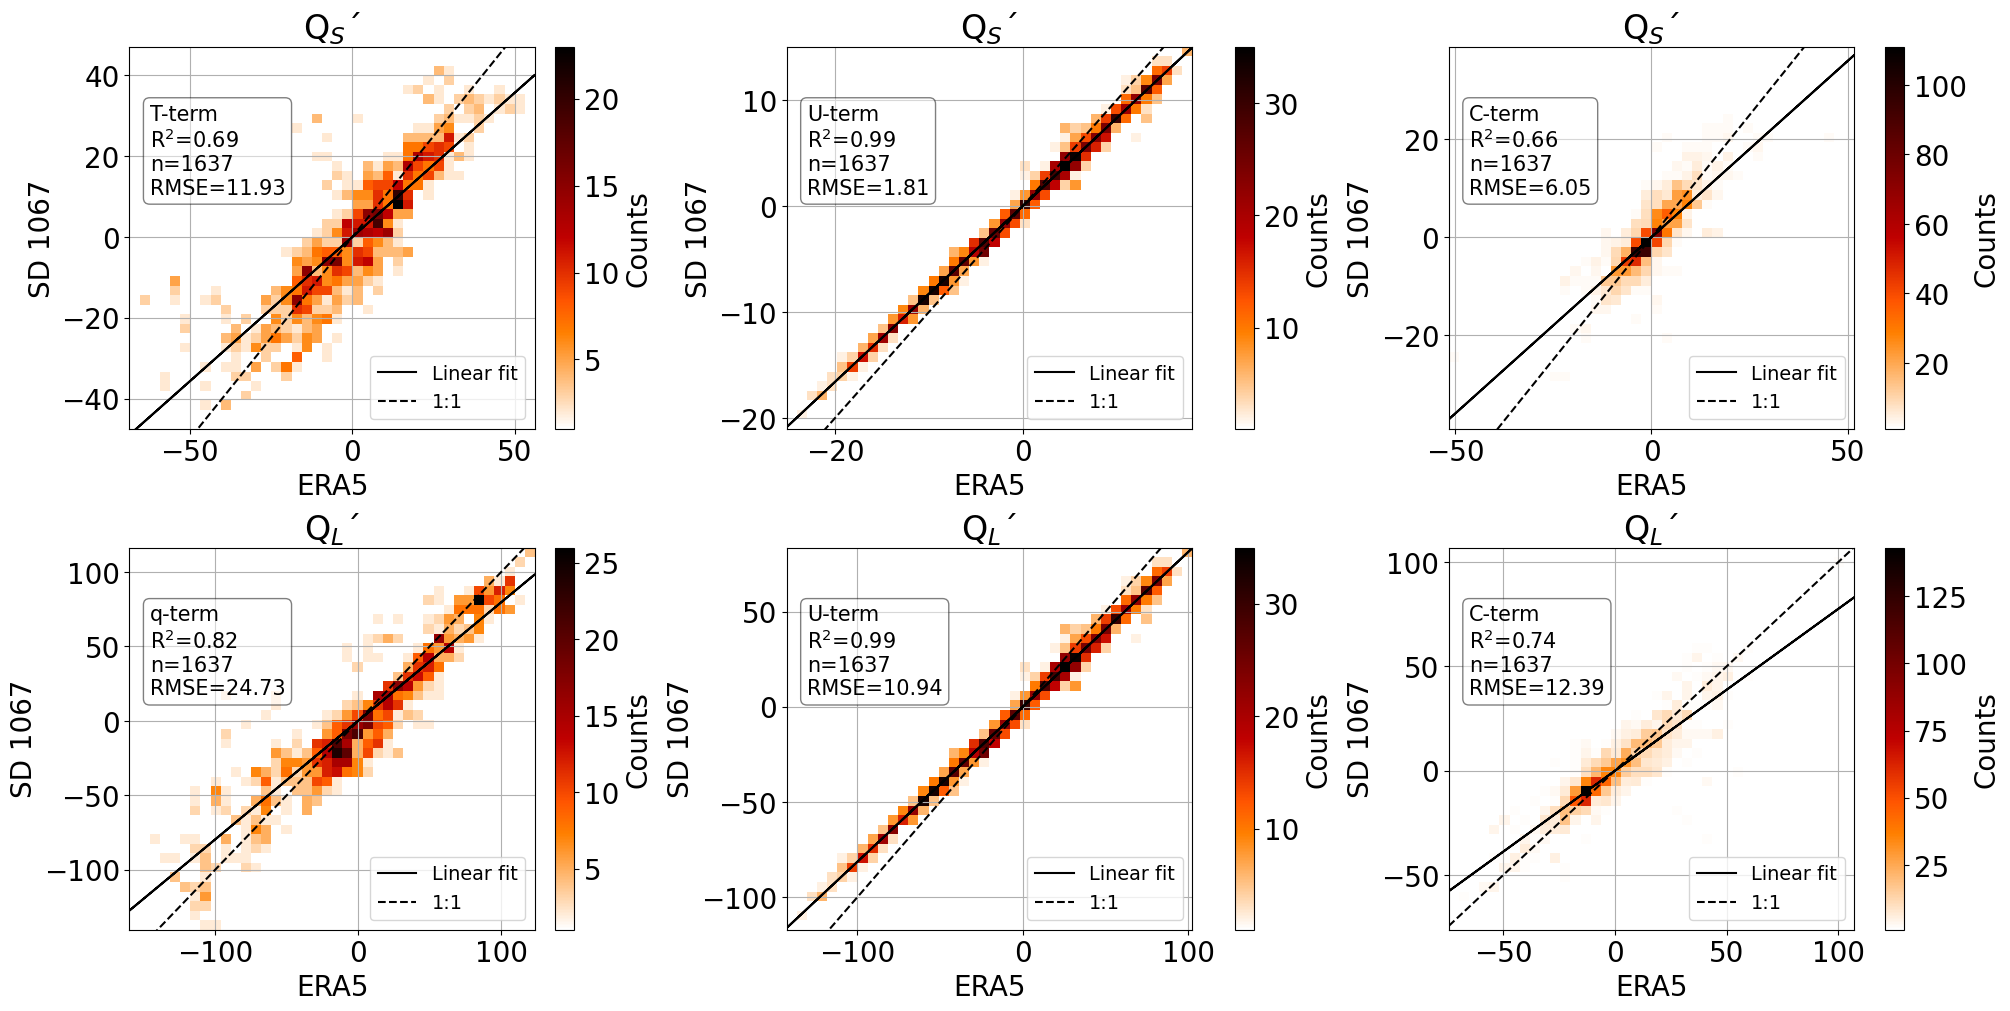

In [80]:
fig, ax=plt.subplots(2,3, figsize=[20,10], constrained_layout=True)

s_terms=['t_term', 'u_term_t', 'cov_term_t']
l_terms=['q_term', 'u_term_q', 'cov_term_q']

labelS = ['T-term', 'U-term', 'C-term']
labelL = ['q-term', 'U-term', 'C-term']

for i in np.arange(3):
    msk=np.isfinite(rec_SD[s_terms[i]])
    
    x= rec_ERA5.shf_coeffs*rec_ERA5[s_terms[i]].sel(index=msk)
    y= rec_SD.shf_coeffs*rec_SD[s_terms[i]].sel(index=msk)
    wind1=ax[0,i].hist2d(x, y, bins=40, cmin=1,cmap='gist_heat_r')
    #ax[0,i].scatter(x, y) #Idea is to color by wind, then we can see if there is issues at high or low windspeeds
    fig.colorbar(wind1[3], ax=ax[0,i], label=('Counts'))
    #Create linear fit line and plot
    
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)
    
    #add linear regression line to scatterplot 
    ax[0,i].plot(x, m*x+b, color='k', label='Linear fit')
    ax[0,i].plot(np.arange(x.min(), x.max(), 1), np.arange(x.min(), x.max(), 1) , linestyle='--', color='k', label=('1:1'))
    #Create stats and statbox
    RMSE = math.sqrt(mean_squared_error(x, y))
    
    r2=scipy.stats.linregress(x, y).rvalue**2
    n = len(x)
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr= labelS[i] + '\n' +'R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax[0,i].annotate(textstr, xy=(0.05, 0.85), xycoords='axes fraction', bbox=props, va='top',fontsize=15)

    msk=np.isfinite(rec_SD[l_terms[i]])
    
    x= rec_ERA5.lhf_coeffs*rec_ERA5[l_terms[i]].sel(index=msk)
    y= rec_SD.lhf_coeffs*rec_SD[l_terms[i]].sel(index=msk)
    
    
    #ax[1,i].scatter(x, y)
    wind2= ax[1,i].hist2d(x, y, bins=40, cmin=1, label=labelL[i],cmap='gist_heat_r')
    fig.colorbar(wind2[3], ax=ax[1,i], label=('Counts'))

    m, b = np.polyfit(x, y, 1)
    
    #add linear regression line to scatterplot 
    ax[1,i].plot(x, m*x+b, color='k', label='Linear fit')
    ax[1,i].plot(np.arange(x.min(), x.max(), 1), np.arange(x.min(), x.max(), 1) , linestyle='--', color='k', label=('1:1'))
    #Create stats and statbox
    RMSE = math.sqrt(mean_squared_error(x, y))
    
    r2=scipy.stats.linregress(x, y).rvalue**2
    n = len(x)
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr= labelL[i] + '\n' +'R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    


    ax[1,i].annotate(textstr, xy=(0.05, 0.85), xycoords='axes fraction', bbox=props, va='top',fontsize=15)

    ax[0,i].set_title('Q$_S´$')
    ax[1,i].set_title('Q$_L´$')
    
    ax[0,i].set_ylabel('SD 1067')
    ax[1,i].set_ylabel('SD 1067')
    
    ax[0,i].set_xlabel('ERA5')
    ax[1,i].set_xlabel('ERA5')
    
    ax[0,i].grid()
    ax[1,i].grid()
    
    ax[0,i].legend(loc='lower right', fontsize='x-small')
    ax[1,i].legend(loc='lower right', fontsize='x-small')
#    mask = ~np.isnan(varprime.Qs) & ~np.isnan(varprime.deltaT)

#    scipy.stats.linregress(varprime.Qs[mask], varprime.deltaT[mask])

    
#plt.savefig('figures/primecorr.png')

colorbars same scale, small on top left corner

# 8.2 Upscaling

In [82]:
ERA5big=ERA5big.rename({'msdwlwrf':'dwlw'})
ERA5big=ERA5big.rename({'msdwswrf':'dwsw'})

Write code for create mean and fluc variables, for-loop per day. Input in a ds, plot for each tays with fluctuations and create animation